In [38]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks
from matplotlib import pyplot as plt

Num_zs = 16
beta_bin = 1

In [39]:
dataframe = pd.read_csv('./Training_beta%d (Cij).csv' %beta_bin)

In [40]:
dataframe.shape

(5000, 33)

In [41]:
dataframe.head()

,fs8_1,sfs8_1,fs8_2,sfs8_2,fs8_3,sfs8_3,fs8_4,sfs8_4,fs8_5,sfs8_5,...,sfs8_12,fs8_13,sfs8_13,fs8_14,sfs8_14,fs8_15,sfs8_15,fs8_16,sfs8_16,target
0,0.028757,0.006291,0.033717,0.00617,0.038449,0.00606,0.042823,0.005988,0.046748,0.005955,...,0.005767,0.061399,0.005687,0.061347,0.005598,0.061107,0.005503,0.060709,0.005402,0.0
1,0.029506,0.006291,0.034542,0.00617,0.039340,0.00606,0.043770,0.005988,0.047741,0.005955,...,0.005767,0.062452,0.005687,0.062384,0.005598,0.062126,0.005503,0.061709,0.005402,0.0
2,0.030265,0.006291,0.035378,0.00617,0.040243,0.00606,0.044729,0.005988,0.048746,0.005955,...,0.005767,0.063515,0.005687,0.063430,0.005598,0.063154,0.005503,0.062719,0.005402,0.0
3,0.031034,0.006291,0.036223,0.00617,0.041156,0.00606,0.045699,0.005988,0.049763,0.005955,...,0.005767,0.064586,0.005687,0.064486,0.005598,0.064191,0.005503,0.063736,0.005402,0.0
4,0.031812,0.006291,0.037079,0.00617,0.042079,0.00606,0.046679,0.005988,0.050789,0.005955,...,0.005767,0.065667,0.005687,0.065549,0.005598,0.065236,0.005503,0.064761,0.005402,0.0


In [42]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 4000 samples for training and 1000 for validation


In [43]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [44]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'fs8_1': <tf.Tensor: shape=(), dtype=float64, numpy=3.3547281422286805>, 'sfs8_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.0062907883211478>, 'fs8_2': <tf.Tensor: shape=(), dtype=float64, numpy=3.3564901538912864>, 'sfs8_2': <tf.Tensor: shape=(), dtype=float64, numpy=0.006169872581862>, 'fs8_3': <tf.Tensor: shape=(), dtype=float64, numpy=3.305188226325648>, 'sfs8_3': <tf.Tensor: shape=(), dtype=float64, numpy=0.0060604502363361>, 'fs8_4': <tf.Tensor: shape=(), dtype=float64, numpy=3.217122639194293>, 'sfs8_4': <tf.Tensor: shape=(), dtype=float64, numpy=0.005988240166869>, 'fs8_5': <tf.Tensor: shape=(), dtype=float64, numpy=3.105682779574428>, 'sfs8_5': <tf.Tensor: shape=(), dtype=float64, numpy=0.0059549134745899>, 'fs8_6': <tf.Tensor: shape=(), dtype=float64, numpy=2.850686078238209>, 'sfs8_6': <tf.Tensor: shape=(), dtype=float64, numpy=0.0059537321804849>, 'fs8_7': <tf.Tensor: shape=(), dtype=float64, numpy=2.719556304385826>, 'sfs8_7': <tf.Tensor: shape=(), dtype=float6

In [45]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [46]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

In [47]:
# Create lists to store inputs and encoded features
all_inputs = []
all_features_encoded = []

# Create inputs and encode numerical features
for i in range(1, Num_zs + 1):
    fs_input = keras.Input(shape=(1,), name=f"fs8_{i}")
    sfs_input = keras.Input(shape=(1,), name=f"sfs8_{i}")

    fs_encoded = encode_numerical_feature(fs_input, f"fs8_{i}", train_ds)
    sfs_encoded = encode_numerical_feature(sfs_input, f"sfs8_{i}", train_ds)

    all_inputs.extend([fs_input, sfs_input])
    all_features_encoded.extend([fs_encoded, sfs_encoded])

# Concatenate all encoded features
all_features = layers.concatenate(all_features_encoded)
x = layers.Dense(38, activation='relu', name='hidden_layer')(all_features)
x = layers.Dropout(0.224)(x)
output = layers.Dense(1, activation="sigmoid", name='output_layer')(x)

model = keras.Model(all_inputs, output)

# Compile the model
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [48]:
NCC_1701_D=model.fit(train_ds, epochs=2000, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/2000
125/125 [==============================] - 2s 8ms/step - loss: 0.6491 - accuracy: 0.6135 - val_loss: 0.5476 - val_accuracy: 0.6760
Epoch 2/2000
125/125 [==============================] - 1s 5ms/step - loss: 0.5425 - accuracy: 0.7107 - val_loss: 0.5165 - val_accuracy: 0.7500
Epoch 3/2000
125/125 [==============================] - 1s 5ms/step - loss: 0.5164 - accuracy: 0.7398 - val_loss: 0.4929 - val_accuracy: 0.7640
Epoch 4/2000
125/125 [==============================] - 1s 6ms/step - loss: 0.4979 - accuracy: 0.7533 - val_loss: 0.4744 - val_accuracy: 0.7640
Epoch 5/2000
125/125 [==============================] - 0s 3ms/step - loss: 0.4834 - accuracy: 0.7575 - val_loss: 0.4654 - val_accuracy: 0.7690
Epoch 6/2000
125/125 [==============================] - 0s 3ms/step - loss: 0.4738 - accuracy: 0.7713 - val_loss: 0.4563 - val_accuracy: 0.7800
Epoch 7/2000
125/125 [==============================] - 1s 4ms/step - loss: 0.4637 - accuracy: 0.7782 - val_loss: 0.4477 - val_accuracy:

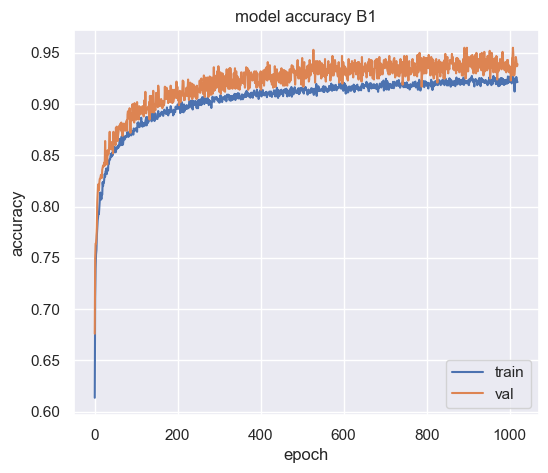

In [49]:
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['accuracy'])
plt.plot(NCC_1701_D.history['val_accuracy'])
plt.title('model accuracy B1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
fig.savefig('./Beta%daccuracy.png' %beta_bin)

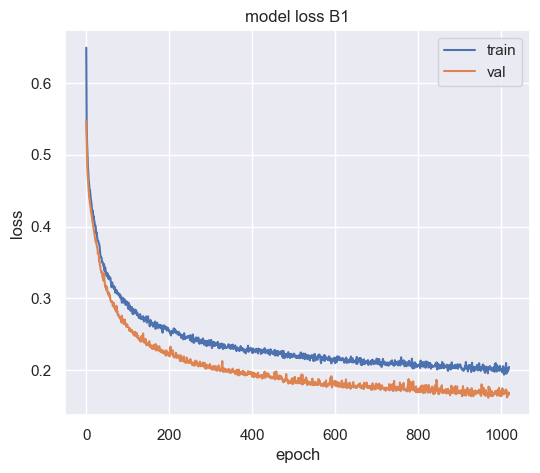

In [50]:
fig = plt.figure(figsize=(6,5))
plt.plot(NCC_1701_D.history['loss'])
plt.plot(NCC_1701_D.history['val_loss'])
plt.title('model loss B1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
fig.savefig('./Beta%dloss.png' %beta_bin)

In [51]:
def norm(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

In [52]:
theory = ['LCDM','MoG']

with open('./Test_Indira_beta%d (Cij).csv' %beta_bin, 'r') as f:
    dict_reader = csv.DictReader(f,quoting=csv.QUOTE_NONNUMERIC)
    test_models = list(dict_reader)

In [53]:
true_model=[]
pred_model=[]
prob_pred=[]
for i in range(len(test_models)):
  sample = test_models[i]
  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()} 
  predictions = model.predict(input_dict)
  true_model.append(round(test_models[i]['target']))
  pred_model.append(round(predictions[0][0]))
  prob_pred.append(round(100*norm(predictions[0][0]),3))

c:\Users\indi_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 45ms/step


In [54]:
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []
for i in range(len(test_models)):
  if(true_model[i]==pred_model[i] and pred_model[i]==0):
    true_LCDM.append(1)
  if(true_model[i]==pred_model[i] and pred_model[i]==1):
    true_MoG.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==0):
    false_LCDM.append(1)
  if(true_model[i]!=pred_model[i] and pred_model[i]==1):
    false_MoG.append(1)  
lens= [len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]
print(lens)
print(sum(lens))

[743, 678, 72, 7]
1500


In [55]:
print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lens),len(true_MoG)/sum(lens))
print('False',len(false_LCDM)/sum(lens),len(false_MoG)/sum(lens))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lens))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lens))

      LCDM MoG
True  0.49533333333333335 0.452
False 0.048 0.004666666666666667
--------------
Correct prediction:  0.9473333333333334
Wrong prediction  :  0.05266666666666667


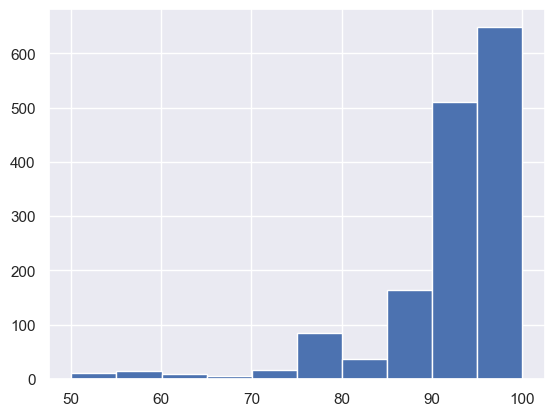

In [56]:
plt.hist(prob_pred)
plt.show() 

Text(42.25, 0.5, 'True Class')

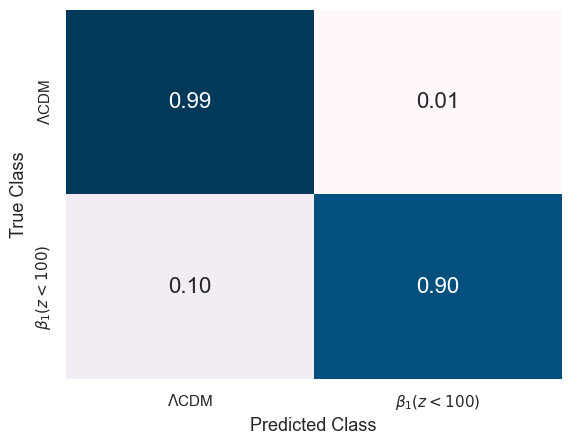

In [57]:
#Confusion matrix
from sklearn import metrics

cm = metrics.confusion_matrix(true_model, pred_model)

#Create normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cm_normalized, cmap='PuBu',annot=True, annot_kws={"size": 16},cbar=False, fmt=".2f",
            xticklabels=[r'$\Lambda$CDM', r'$\beta_1(z<100)$'],
            yticklabels=[r'$\Lambda$CDM', r'$\beta_1(z<100)$'])#, 
            # xticklabels=['$\Lambda$CDM', 'HS'],
            # yticklabels=['$\Lambda$CDM', 'HS'])

plt.yticks(rotation=90)

plt.xlabel('Predicted Class',fontsize=13)
plt.ylabel('True Class',fontsize=13)